In [2]:
import os
from tqdm import notebook
from datetime import datetime
import pickle

import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from tqdm import notebook

from scoring_utils import PLAYER_SCORE, normal_round
from constants import DATA_DIR, SEASONS

pd.set_option('display.max_columns', 500)

# Merge all players' averages together

In [29]:
%%script false --no-raise-error

_, _, dataframes = next(os.walk(f'{DATA_DIR}/PlayersAverages'))

df = pd.read_csv(f'{DATA_DIR}/PlayersAverages/{dataframes[0]}')
df.reset_index(inplace=True)
df.rename({'index': 'NAME'}, inplace=True, axis=1)

for frame in notebook.tqdm(dataframes[1:]):
    temp = pd.read_csv(f'{DATA_DIR}/PlayersAverages/{frame}')
    temp.reset_index(inplace=True)
    temp.rename({'index': 'NAME'}, inplace=True, axis=1)
    
    df = df.append(temp)
    df.reset_index(drop=True, inplace=True)
    
df.to_csv(f'{DATA_DIR}/PlayersAverages/averages.csv', index_label=False)

  0%|          | 0/2351 [00:00<?, ?it/s]

## Questions on players' averages

* [Which ones are the best individual seasons? And the worst?](#G1)

* [Who has the best average over his career? And the worst?](#G2)

In [60]:
with open(f'{DATA_DIR}/players.pkl', 'rb') as fp:
        players = pickle.load(fp)
        
df = pd.read_csv(f'{DATA_DIR}/PlayersAverages/averages.csv')

*Which ones are the best individual seasons? And the worst?* <a id="G1"></a>

OSS: At least 40 games played!

In [62]:
filt = df.N_GAMES >= 40
temp = df.loc[filt]

temp = temp.sort_values('PDK')

worst = temp.head(10)
best = temp.tail(10).sort_values('PDK', ascending=False)

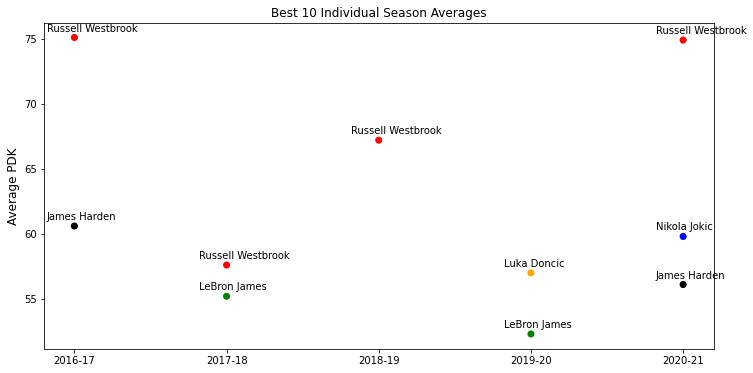

In [261]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

plot_best = best[['NAME', 'SEASON', 'PDK']].sort_values('SEASON')

colors = {'Russell Westbrook': 'red', 'James Harden': 'black', 'Nikola Jokic': 'blue', 'Luka Doncic': 'orange', 'LeBron James': 'green'}

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(plot_best.SEASON, plot_best.PDK, c=plot_best.NAME.map(colors))

data = {}
idx = 0
for i in range(len(plot_best.SEASON)):
    if plot_best.SEASON.tolist()[i] not in data.keys():
        data[plot_best.SEASON.tolist()[i]] = idx
        idx += 1

for i in range(10):
    ax.annotate(plot_best.NAME.tolist()[i], (data[plot_best.SEASON.tolist()[i]] - 0.18, plot_best.PDK.tolist()[i] + 0.5))

plt.title('Best 10 Individual Season Averages')
plt.ylabel('Average PDK', fontsize=12)
plt.show()

*What is best career average?* <a id="G2"></a>

with at least 25 games averaged per season

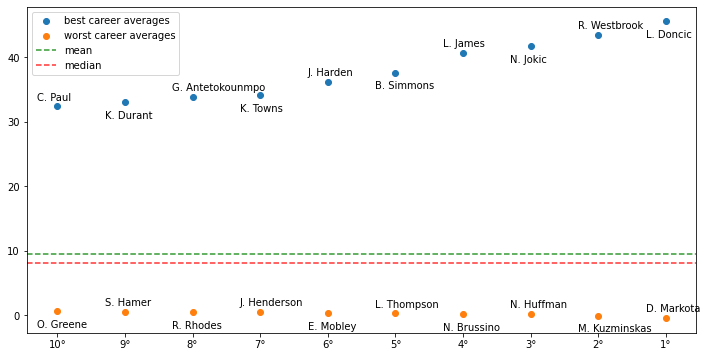

In [233]:
player_avg = df.groupby('NAME').mean().sort_values('PDK', ascending=False).reset_index().rename({'index': 'NAME'}, axis=1)
filt = player_avg.N_GAMES > 25
player_avg = player_avg.loc[filt]

best_player_avg = player_avg.head(10)[['NAME', 'PDK']]
worst_player_avg = player_avg.tail(10)[['NAME', 'PDK']].sort_values('PDK')

best_player_avg['NAME'] = best_player_avg['NAME'].apply(lambda x: '. '.join([x.split(' ')[0][0], x.split(' ')[1]]))
worst_player_avg['NAME'] = worst_player_avg['NAME'].apply(lambda x: '. '.join([x.split(' ')[0][0], x.split(' ')[1]]))

f, ax = plt.subplots(figsize=(12, 6))

plt.scatter(np.arange(10), best_player_avg.PDK[::-1], label='best career averages')
plt.scatter(np.arange(10), worst_player_avg.PDK[::-1], label='worst career averages')
plt.axhline(y=player_avg.PDK.mean(), label='mean', linestyle='--', color='green', alpha=0.8)
plt.axhline(y=player_avg.PDK.median(), label='median', linestyle='--', color='red', alpha=0.8)
plt.xticks(np.arange(10), [f'{x}°' for x in range(1, 11)][::-1])

for i in range(10):
    if i % 2 == 0:
        ax.annotate(best_player_avg.NAME.tolist()[i], (8.7-i, best_player_avg.PDK.tolist()[i] - 2.5))
        ax.annotate(worst_player_avg.NAME.tolist()[i], (8.7-i, worst_player_avg.PDK.tolist()[i] + 1))
    else:
        ax.annotate(best_player_avg.NAME.tolist()[i], (8.7-i, best_player_avg.PDK.tolist()[i] + 1))
        ax.annotate(worst_player_avg.NAME.tolist()[i], (8.7-i, worst_player_avg.PDK.tolist()[i] - 2.5))

plt.legend()
plt.show()

*What is the average, best and worst performace per season?* <a id="G3"></a>

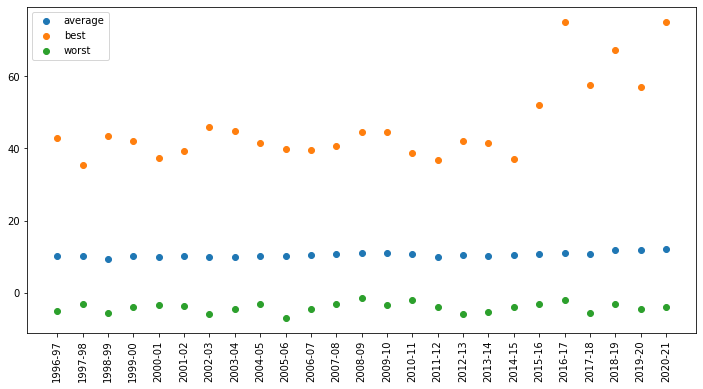

In [155]:
avg = df.groupby('SEASON').mean()[['PDK']].reset_index().rename({'index': 'SEASON'}, axis=1)

best_per_seasons = df.loc[(df.SEASON==SEASONS[0])].sort_values('PDK', ascending=False).head(1)
for season in SEASONS[1:]:
    temp = df.loc[(df.SEASON==season)].sort_values('PDK', ascending=False).head(1)
    best_per_seasons = best_per_seasons.append(temp)

worst_per_seasons = df.loc[(df.SEASON==SEASONS[0])].sort_values('PDK', ascending=True).head(1)
for season in SEASONS[1:]:
    temp = df.loc[(df.SEASON==season)].sort_values('PDK', ascending=True).head(1)
    worst_per_seasons = worst_per_seasons.append(temp)
    
    
f, ax = plt.subplots(figsize=(12, 6))
plt.scatter(avg.SEASON, avg.PDK, label='average')
plt.scatter(best_per_seasons.SEASON, best_per_seasons.PDK, label='best')
plt.scatter(worst_per_seasons.SEASON, worst_per_seasons.PDK, label='worst')

#plt.plot(avg.SEASON, avg.PDK, label='average')
#plt.plot(best_per_seasons.SEASON, best_per_seasons.PDK, label='best')
#plt.plot(worst_per_seasons.SEASON, worst_per_seasons.PDK, label='worst')

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [150]:
worst_per_seasons

,NAME,SEASON,N_GAMES,TEAMS,WINS,LOSSES,MP,ST,FG,FGA,FG_perc,3P,3PA,3P_perc,FT,FTA,FT_perc,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,BPM,BA,PDK
7658,Cuonzo Martin,1996-97,3,['MIL'],0,3,04:20,0,0.0,2.3,0.000,0.0,0.7,0.0,0.0,0.0,0.000,0.3,0.0,0.3,0.3,0.0,0.0,0.3,0.3,0.0,-0.7,-28.4,0.0,-4.9
7646,Bob McCann,1997-98,1,['TOR'],0,1,05:03,0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.0,-17.4,0.0,-3.0
4843,LaMark Baker,1998-99,1,['TOR'],0,1,01:35,0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,-63.7,0.0,-5.5
7139,Kiwane Garris,1999-00,3,['ORL'],0,3,07:14,0,0.7,3.3,0.212,0.0,0.3,0.0,0.0,0.0,0.000,0.0,0.3,0.3,0.7,0.0,0.0,0.3,0.0,1.3,4.0,-35.8,0.7,-3.8
4098,Lari Ketner,2000-01,3,['IND'],0,3,01:59,0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.3,0.0,0.0,0.7,0.0,0.0,-0.3,-11.8,0.0,-3.5
2335,Ernest Brown,2001-02,3,['MIA'],0,3,07:02,0,0.3,2.0,0.150,0.0,0.0,0.0,0.3,1.3,0.231,0.3,1.7,2.0,0.0,0.0,0.3,1.0,1.3,1.0,-7.3,-14.7,0.0,-3.6
5471,Don Reid,2002-03,1,['DET'],0,1,10:00,0,0.0,3.0,0.000,0.0,0.0,0.0,1.0,2.0,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-5.0,-27.5,0.0,-6.0
7715,Tierre Brown,2003-04,3,['NOH'],0,3,06:05,0,0.7,1.3,0.538,0.0,0.0,0.0,0.7,1.3,0.538,0.0,0.3,0.3,0.7,0.0,0.0,2.3,0.3,2.0,-6.7,-21.1,0.0,-4.5
2216,Brandin Knight,2004-05,1,['HOU'],0,1,02:47,0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-9.4,1.0,-3.0
7119,Nene Hilario,2005-06,1,['DEN'],0,1,02:33,0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,-6.0,-70.7,0.0,-7.0
